In [92]:
import hopsworks
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
#os.environ['HOPSWORKS_API_KEY'] = 'cKV1tKzokpcwviY6.uP2qcFV2wWI8xxNu1I0UxyeqlRHqSEanLgKFjf5R1ypSy8A3AUnRkRpi0R9Gc5l0'

In [93]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/195738
Connected. Call `.close()` to terminate connection gracefully.


In [95]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=2)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=2,
                                  description="Read from wine quality dataset",
                                  labels=["quality_label"],
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/195738/fs/195657/fv/wine/version/2


In [120]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.59s) 


In [121]:
X_train

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,ph,sulphates,alcohol
0,1,7.0,0.16,0.26,7.3,0.047,30.0,0.99622,3.38,0.58,10.1
1,0,7.0,0.51,0.09,2.1,0.062,4.0,0.99584,3.35,0.54,10.5
3,1,6.6,0.34,0.25,4.8,0.038,16.0,0.99198,3.36,0.71,12.6
4,1,6.8,0.28,0.36,8.0,0.045,28.0,0.99280,3.02,0.37,11.4
6,1,7.1,0.31,0.38,1.2,0.036,10.0,0.99240,3.14,0.44,9.9
...,...,...,...,...,...,...,...,...,...,...,...
5317,1,9.2,0.27,0.34,10.5,0.043,49.0,0.99740,3.04,0.41,10.4
5318,1,5.9,0.18,0.28,5.1,0.039,50.0,0.99165,3.16,0.44,11.3
5319,1,5.8,0.40,0.42,4.4,0.047,38.5,0.99370,3.25,0.57,9.6
5320,1,6.0,0.19,0.29,1.2,0.046,29.0,0.99033,3.22,0.53,11.3


In [122]:
y_train

,quality_label
0,medium
1,medium
3,medium
4,medium
6,medium
...,...
5317,medium
5318,medium
5319,medium
5320,medium


In [123]:
# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
# We iterate over different values of K to find the best performing model
k_neighbors = range(2 , 11 , 2)
Training_acc = []
Testing_acc = []

for i in k_neighbors:
    print(f'K = {i}')
    model = KNeighborsClassifier(n_neighbors= i)
    model.fit(X_train , y_train.values.ravel())
    Training_acc.append(model.score(X_train , y_train))
    Testing_acc.append(model.score(X_test , y_test))
    
print(f'Training accuracy: f{Training_acc}')
print(f'Testing accuracy: f{Testing_acc}')

K = 2
K = 4
K = 6
K = 8
K = 10
Training accuracy: f[0.8520084566596194, 0.8235846840498003, 0.8087855297157622, 0.8071411792342025, 0.8071411792342025]
Testing accuracy: f[0.6732394366197183, 0.7192488262910798, 0.7502347417840376, 0.7530516431924883, 0.7680751173708921]


As we can see by the displyed accuracies, k=10 is the best value for k

In [126]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train.values.ravel())

# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [130]:
print(metrics)

{'good': {'precision': 0.532258064516129, 'recall': 0.3235294117647059, 'f1-score': 0.402439024390244, 'support': 204}, 'medium': {'precision': 0.7995735607675906, 'recall': 0.927070457354759, 'f1-score': 0.8586147681740125, 'support': 809}, 'poor': {'precision': 0.6666666666666666, 'recall': 0.038461538461538464, 'f1-score': 0.07272727272727274, 'support': 52}, 'accuracy': 0.7680751173708921, 'macro avg': {'precision': 0.6661660973167954, 'recall': 0.42968713586033447, 'f1-score': 0.4445936884305097, 'support': 1065}, 'weighted avg': {'precision': 0.741880115013087, 'recall': 0.7680751173708921, 'f1-score': 0.7328626540940882, 'support': 1065}}


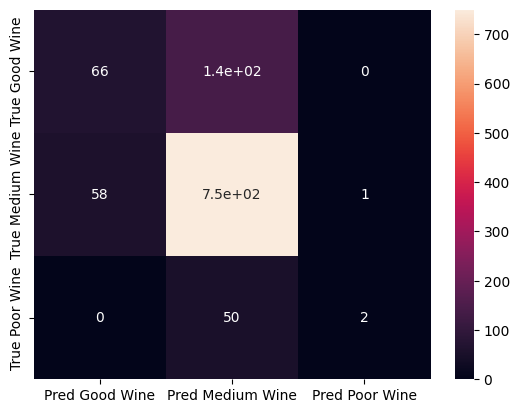

In [131]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Good Wine', 'True Medium Wine', 'True Poor Wine'],
                     ['Pred Good Wine', 'Pred Medium Wine', 'Pred Poor Wine'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [132]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 872534/872534 elapsed<00:04 remaining<00:00  2.40it/s]
Uploading: 100.000%|██████████| 25694/25694 elapsed<00:01 remaining<00:002,  2.40it/s]
Uploading: 100.000%|██████████| 990/990 elapsed<00:01 remaining<00:00<00:16,  4.17s/it]
Model export complete: 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/195738/models/wine_model/1


Model(name: 'wine_model', version: 1)